In [1]:
# In order to force the reload of modules
# %load_ext autoreload
# %autoreload 2

# In order to make the import of local modules
import sys
sys.path.append('../..')

import abc
from collections import *
from dataclasses import *
import enum
import gym
import heapq
import numpy as np
import pandas as pd
import random
from tqdm import tqdm, trange
# from tqdm import tnrange, tqdm_notebook
from typing import *

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
"""
Utilities
"""


import time


g_iteration_nb = 0
g_previous_time = None


def print_progress(done, total):
    global g_previous_time, g_iteration_nb
    g_iteration_nb += 1
    current_time = time.time_ns()
    if g_previous_time is not None:
        delay_ms = (current_time - g_previous_time) / 1_000_000
        if delay_ms > 100:
            throughput = g_iteration_nb / delay_ms * 1_000
            sys.stdout.write("\x1b[A") # Clear the line
            sys.stdout.write("{0}/{1} ({2:.2f}%) - {3:.2f} it/s".format(done, total, 100*done/total, throughput))
            sys.stdout.write("\r")
            g_iteration_nb = 0
            g_previous_time = time.time_ns()
    else:
        g_previous_time = time.time_ns()
    

def prange(end_range: int):
    print_progress(0, end_range)
    for i in range(end_range):
        print_progress(i+1, end_range)
        yield i
    sys.stdout.write("\n")
    
    
"""
Test
"""

for _ in prange(10):
    time.sleep(0.5)
print("Solved!")

10/10 (100.00%) - 1.99 it/s
Solved!


In [15]:
"""
Definition of an agent
"""


class Agent(abc.ABC):
    """
    Basic interface for any agent acting on an environment, in a given state
    """

    @abc.abstractmethod
    def get_action(self, env, state):
        pass


"""
Trying the agent on cartpole
"""


def try_agent(agent: Agent, show=True):
    with gym.make("CartPole-v0") as env:
        total_reward = 0.0
        obs = env.reset()
        if show:
            env.render()
        done = False
        while not done:
            action = agent.get_action(env, obs)
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            if show:
                env.render()
        if show:
            print("Total reward {0:.2f}".format(total_reward))
        return total_reward

    
def evaluate_performance(agent: Agent, episodes: int = 100):
    total_reward = 0.0
    for _ in range(episodes):
        total_reward += try_agent(agent, show=False)
    print("Average performance:", total_reward / episodes)
    

"""
Random agent
"""

class RandomAgent(Agent):
    def get_action(self, env, state):
        return env.action_space.sample()


# try_agent(RandomAgent())
evaluate_performance(RandomAgent())

Total reward 18.00
Average performance: 22.36


In [16]:
"""
Manual agent (does not take account of speed)
"""


class BrutalAgent(Agent):
    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        if theta < 0.02:
            return 0
        elif theta > 0.02:
            return 1
        return 0


# try_agent(BrutalAgent())
evaluate_performance(RandomAgent())

Average performance: 22.83


In [23]:
"""
Application of PID circuit (limited to linear systems):

The idea is to have closed loop circuit (compared the the open circuit with no feedback) and to minimize
an erreur between what is desired G (goal), and what is obtained R (result).

We have three quantities:
* Potential(E) = E = criterion on (G - R)
* Integral(E) = accumulate the error over time
* Derivative(E) = derivative of the error over time

In linear system, you have:
* R = A (amplification) * E (error)
* E = G - R
=> R = A * (G - R)
=> R * (1 + A) = G * A
=> R / G = A / (1 + A)

We want R = G, so we want A to be big, but there will always be a static error.
So we could wich to increase A enormously, but then the curve will overshoot at first, by a large margin.
=> The goal is to have A vary with time (any static A will fail)

We look for 3 coeficients Kp, Ki and Kd, such that:
A = Kp * Potential(E) + Ki * Integral(E) + Kd * Derivative(d)

Actually, we also search a fourth constant K, such that
A = Kp * Potential(E) + Ki * Integral(E) + Kd * Derivative(d) + K

Another way to see this is that we modify the error E to make sure that the circuit will act on the output correctly.

The BIG DIFFICULTY here, is that we do not have a perfect control of the input (just the LEFT or RIGHT) and that
we have discretized inputs.
"""


class PIDAgent(abc.ABC):
    def __init__(self, kp=1., ki = 0.1, kd=0.03):
        self.int_error = 0
        self.kp = kp
        self.ki = ki
        self.kd = kd

    def get_action(self, env, state):
        x, x_dot, theta, theta_dot = state
        error = theta
        self.int_error += error
        amplification = self.kp * error + self.ki * self.int_error + self.kd * theta_dot
        if amplification > 0:
            return 1
        else:
            return 0
    
    def __repr__(self):
        return "PID(kd=" + str(self.kd) + ", ki=" + str(self.ki) + ", kd=" + str(self.kd) + ")"


agents = [PIDAgent(kp=1., ki = 0.0, kd=0.3),
          PIDAgent(kp=1., ki = 0.0, kd=0.03),
          PIDAgent(kp=1., ki = 0.0, kd=0.01),
          PIDAgent(kp=1., ki = 0.0, kd=3.),
          PIDAgent(kp=1., ki = 0.0, kd=0.)]

for i, agent in enumerate(agents):
    if i > 0:
        print()
    print(agent)
    evaluate_performance(agent)

PID(kd=0.3, ki=0.0, kd=0.3)
Average performance: 200.0

PID(kd=0.03, ki=0.0, kd=0.03)
Average performance: 200.0

PID(kd=0.01, ki=0.0, kd=0.01)
Average performance: 86.62

PID(kd=3.0, ki=0.0, kd=3.0)
Average performance: 191.96

PID(kd=0.0, ki=0.0, kd=0.0)
Average performance: 42.21


In [24]:
"""
Demonstration
"""


agent = PIDAgent(kp=1., ki = 0.0, kd=0.3)
try_agent(agent)

Total reward 200.00


200.0

In [6]:
"""
GENETIC ALGORITHM APPROACH?
- must have a genome if fixed length + a fitness function
"""


print("TODO")

TODO


Solved!


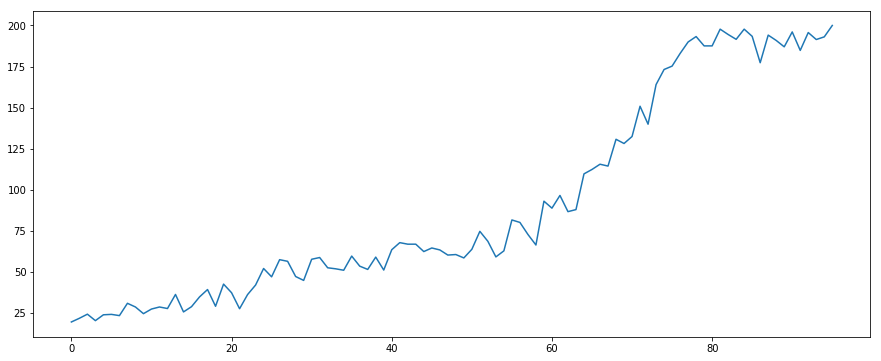

In [9]:
"""
CROSS ENTROPY METHOD:
- Start with a random policy
- Play N episodes with the current policy
- Take the episodes above a reward boundary (typically percentile 70th)
- Train on these "Elite" episodes (throw away the uninteresting ones)

Looks like a kind of GENETIC ALGORITHM stuff, in fact it is a RANDOMIZED BEAM SEARCH kind of stuff
(the same thing as genetic algorithm, without the cross-over operation).
"""


"""
Implementation of a policy P(action | state) to learn via a Neural Net
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(4, 20), nn.ReLU(), nn.Linear(20, 2))
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, state, with_softmax=True):
        ys = self.fc(state)
        if with_softmax:
            ys = self.softmax(ys)
        return ys

    
class PolicyAgent(Agent):
    def __init__(self, policy_net: nn.Module):
        self.policy_net = policy_net
    
    def get_action(self, env, state):
        state = torch.FloatTensor(state)
        action_probs = self.policy_net(state, with_softmax=True)
        distribution = torch.distributions.categorical.Categorical(action_probs)
        return distribution.sample().item()
    
    
"""
Cross Entropy learning
"""


@dataclass(frozen=False)
class EpisodeOutcome:
    states: List[np.ndarray] = field(default_factory=list)
    actions: List[int] = field(default_factory=list)
    score: float = 0.


def play_episode(env, policy: nn.Module) -> EpisodeOutcome:
    outcome = EpisodeOutcome()
    policy = PolicyAgent(policy)
    state = env.reset()
    done = False
    while not done:
        action = policy.get_action(env, state)
        outcome.states.append(state)
        outcome.actions.append(action)
        state, reward, done, _ = env.step(action)
        outcome.score += reward
    return outcome


def to_data_set(episodes: List[EpisodeOutcome]) -> data.TensorDataset:
    xs, ys = [], []
    for episode in episodes:
        xs.extend(episode.states)
        ys.extend(episode.actions)
    return data.TensorDataset(torch.FloatTensor(xs), torch.LongTensor(ys))


def improve_policy(policy: nn.Module, episodes: List[EpisodeOutcome], iteration_nb: int, learning_rate: float):
    policy.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
    loader = data.DataLoader(to_data_set(episodes), batch_size=100, shuffle=True)
    for _ in range(iteration_nb):
        for states, actions in loader:
            optimizer.zero_grad()
            got = policy(states, with_softmax=False)
            loss = criterion(got, actions)
            loss.backward()
            optimizer.step()


def print_progession(score: float):
    if score < 200.:
        print(score, end='\r')
    else:
        sys.stdout.write("\x1b[A") # Clear the line
        print("Solved!")
            

def train_cross_entropy(env, policy: nn.Module,
                        iteration_count: int = 100,
                        batch_size: int = 1000,
                        batch_threshold: float = 0.7,
                        batch_iterations: int = 100,
                        learning_rate: float = 1e-1) -> List[float]:
    mean_scores = []
    for _ in range(iteration_count):
        episodes = [play_episode(env, policy) for _ in range(batch_size)]
        mean_score = np.mean([e.score for e in episodes])
        mean_scores.append(mean_score)
        print_progession(mean_score)
        if mean_score >= 200:
            break
        
        episodes.sort(key=lambda e: e.score)
        episodes = episodes[int(batch_threshold * batch_size):]
        improve_policy(policy, episodes, batch_iterations, learning_rate)
    return mean_scores


"""
Test with the policy of a neural net
"""


with gym.make("CartPole-v0") as env:
    policy_net = PolicyNet()
    scores = train_cross_entropy(env, policy_net,
                                 iteration_count=100, batch_size=16, batch_threshold=0.7,
                                 batch_iterations=5, learning_rate=1e-1)
    plt.figure(figsize=(15, 6))
    plt.plot(scores)
    plt.show()

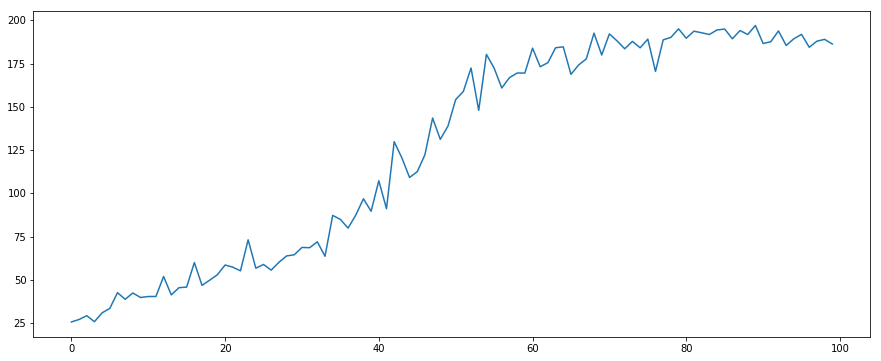

In [11]:
"""
A simpler neural net (the PID manages with just 3 variables)
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(4, 2)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, state, with_softmax=True):
        ys = self.fc(state)
        if with_softmax:
            ys = self.softmax(ys)
        return ys

    
"""
Test with the policy of a neural net
"""


with gym.make("CartPole-v0") as env:
    policy_net = PolicyNet()
    scores = train_cross_entropy(env, policy_net,
                                 iteration_count=100, batch_size=16, batch_threshold=0.7,
                                 batch_iterations=5, learning_rate=1e-1)
    plt.figure(figsize=(15, 6))
    plt.plot(scores)
    plt.show()

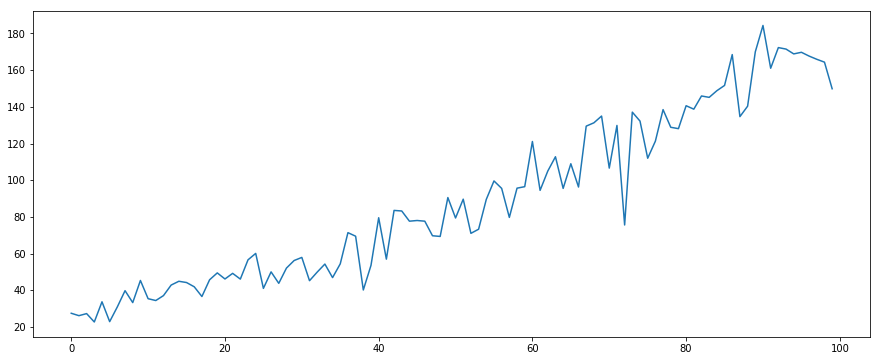

In [8]:
class PolynomialRegressionNet(nn.Module):
    def __init__(self):
        super().__init__()
        feature_size = self._transform(torch.zeros(4)).shape[0]
        self.fc = nn.Linear(feature_size, 2)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, observations, with_softmax=False):
        if len(observations.shape) == 2:
            xs = torch.stack([self._transform(observation) for observation in observations])
        else:
            xs = self._transform(observations)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys)
        return ys
    
    def _transform(self, observation):
        xs = list(observation)
        k = len(observation)
        for i in range(k-1):
            for j in range(i+1, k):
                xs.append(observation[i] * observation[j])
        return torch.FloatTensor(xs)
    

"""
Test with the policy of a neural net
"""


with gym.make("CartPole-v0") as env:
    polynomial_net = PolynomialRegressionNet()
    scores = train_cross_entropy(env, polynomial_net,
                                 iteration_count=100, batch_size=16, batch_threshold=0.7,
                                 batch_iterations=5, learning_rate=1e-1)
    plt.figure(figsize=(15, 6))
    plt.plot(scores)
    plt.show()

 63%|██████▎   | 629/1000 [00:17<00:37,  9.96it/s] 

Solved!


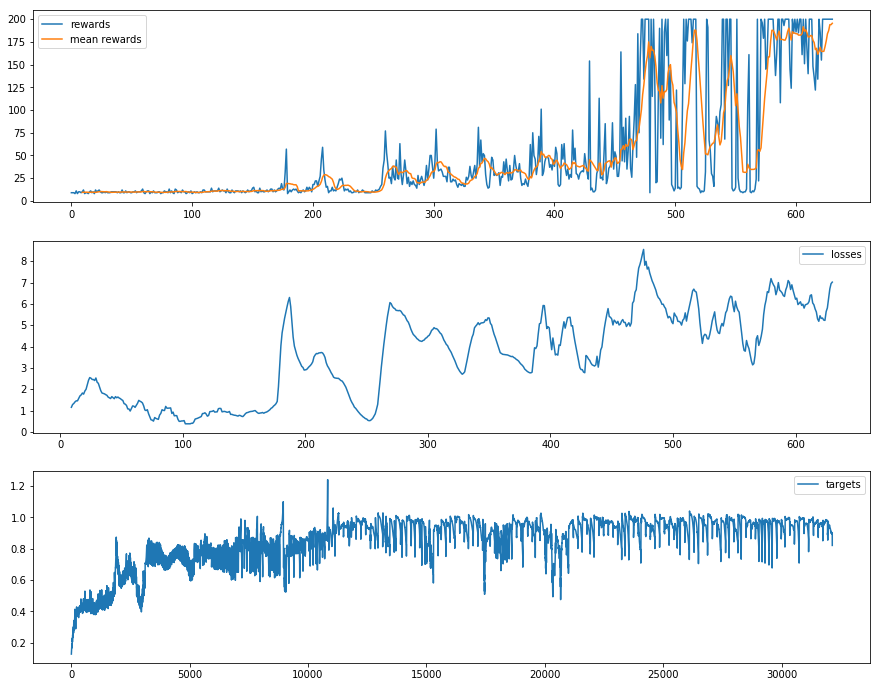

 63%|██████▎   | 629/1000 [00:30<00:37,  9.96it/s]

In [3]:
"""
With Deep SARSA Learning
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 2))

    def forward(self, xs):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        return ys

    
class PolicyAgent:
    def __init__(self, sarsa_net):
        self.sarsa_net = sarsa_net
        
    def get_action(self, env, state):
        action_values = self.sarsa_net(state)
        _, i = torch.max(action_values, dim=-1)
        return i.item()

    
def epsilon_greedy_action(policy: nn.Module, state, epsilon) -> Tuple[int, float]:
    action_values = policy(state)
    if np.random.rand(1) < epsilon:
        action = env.action_space.sample()
        return action, action_values[action]
    else:
        action_value, action = torch.max(action_values, dim=-1)
        return action.item(), action_value
    

def train_sarsa_learning(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float,
    epsilon: float,
    show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        action, action_value = epsilon_greedy_action(policy, state, epsilon)
        while not done:
            next_state, reward, done, _ = env.step(action)
            next_action, next_action_value = epsilon_greedy_action(policy, next_state, epsilon)
            
            # Apply the bellman update
            optimizer.zero_grad()
            if not done:
                target = reward + discount * next_action_value.detach()
            else:
                target = torch.tensor(reward)
            loss = criterion(action_value, target)
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
            
            # Moving to next state
            episode_reward += reward
            state = next_state
            action = next_action
            action_value = next_action_value
            targets.append(target)

        # Criteria of success
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()

    
"""
Training
"""

sarsa_net = PolicyNet()
with gym.make("CartPole-v0") as env:
    train_sarsa_learning(
        env, policy=sarsa_net, episodes=1000, discount=0.9,
        learning_rate=1e-3, weight_decay=0.0,
        epsilon=0.1)

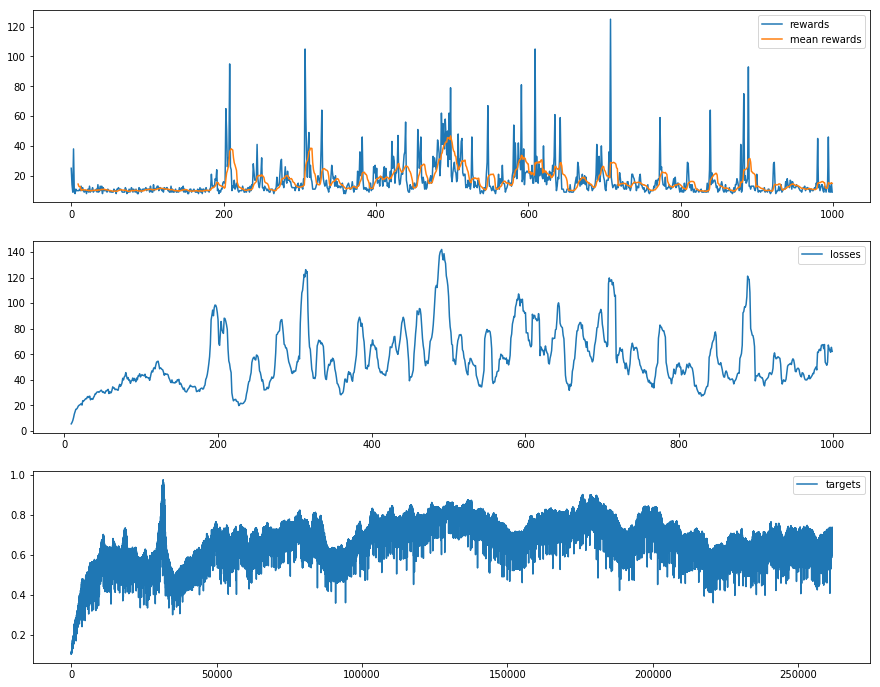

In [6]:
"""
With Deep Q Learning
"""


def train_q_learning(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float,
    epsilon: float,
    show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    replay_buffer = deque(maxlen=1000)
    
    count_success = 0
    for _ in prange(episodes):        
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        while not done:
            action, action_value = epsilon_greedy_action(policy, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            # Storing into the replay buffer
            replay_buffer.append((state, action, next_state, done))
            
            # Extract a mini batch from the replay buffer
            if len(replay_buffer) >= 100:
                losses = []
                for s, a, s2, d in random.choices(replay_buffer, k=16):
                    next_action_values = policy(s2)
                    if not d:
                        next_action_value, _ = torch.max(next_action_values, dim=-1)
                        target = reward + discount * next_action_value.detach()
                    else:
                        target = torch.tensor(reward)
                    losses.append(criterion(action_value, target))
                    targets.append(target)
            
                # Apply the bellman update
                optimizer.zero_grad()
                loss = sum(losses)
                loss.backward()
                optimizer.step()
                episode_loss += loss
            
            # Moving to next state
            episode_reward += reward
            state = next_state
        
        # Criteria of success
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()


"""
Training
"""


with gym.make("CartPole-v0") as env:
    train_q_learning(
        env, policy=PolicyNet(), episodes=1000, discount=0.9,
        learning_rate=1e-3, weight_decay=0.0,
        epsilon=0.1)

Solved!/2000 (69.75%) - 12.65 it/s


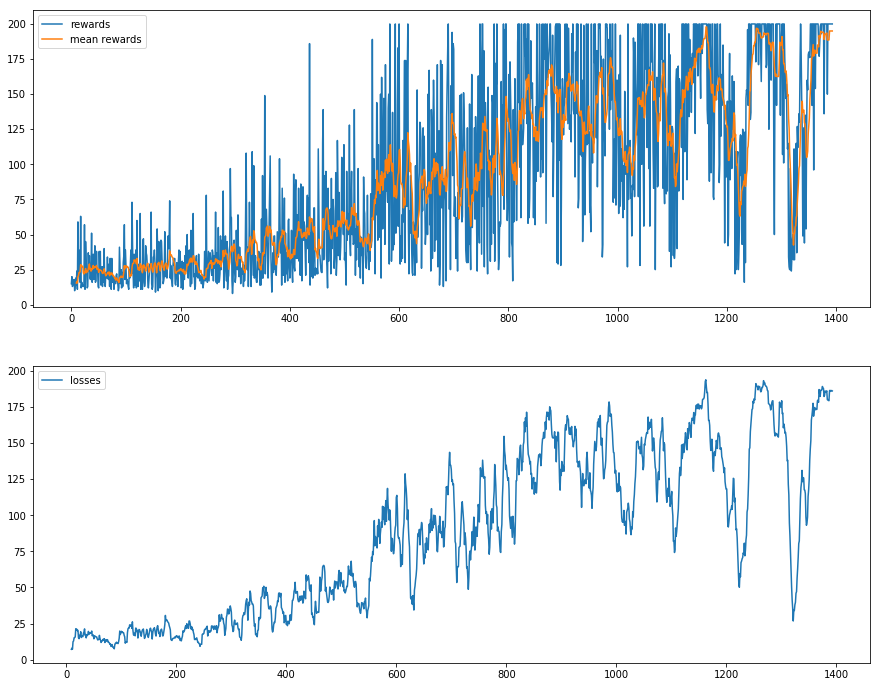

In [38]:
"""
REINFORCE: Monte Carlo Policy Gradient
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 2))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            ys = self.softmax(ys)
        return ys


def train_reinforce(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for _ in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        # Generate a full episode, following the current policy
        moves = []
        done = False
        state = env.reset()
        while not done:
            probs = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            moves.append((state, action, reward))
            state = next_state
        
        # The success criteria
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Add the moves and their outcome in a minibatch
        minibatch = []
        cum_reward = 0.0
        for state, action, reward in reversed(moves):
            cum_reward = reward + discount * cum_reward
            minibatch.append((state, action, cum_reward))
        
        # Optimize the neural net
        policy_losses = []
        for state, action, reward in minibatch:
            probs = policy(state, with_softmax=True)
            prob = probs[action]
            log_prob = torch.log(prob)
            policy_losses.append(- log_prob * reward) # -1 because we want to optimize toward high values
        
        # Adapt weights
        optimizer.zero_grad()
        loss = sum(policy_losses)
        loss.backward()
        optimizer.step()        
        episode_loss = loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=2)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_reinforce(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)

Solved!/2000 (53.75%) - 9.96 it/ss


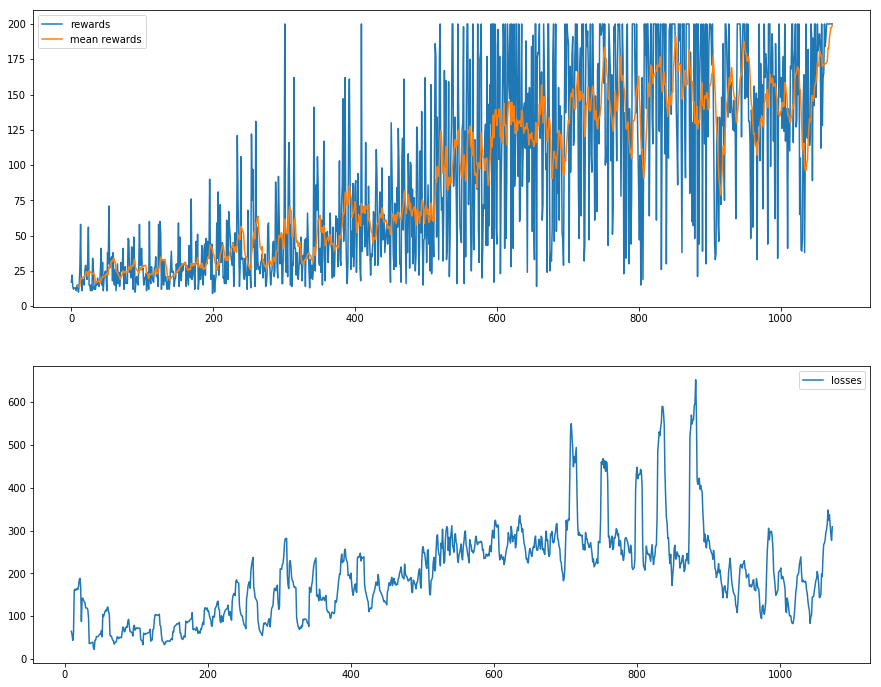

In [36]:
"""
REINFORCE + BASELINE: Monte Carlo Policy Gradient
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(4, 100),
            nn.ReLU(),
            nn.Linear(100, 3))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys[:2]), ys[2:]
        return ys[:2], ys[2:]


def train_reinforce_baseline(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    count_success = 0
    for _ in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        # Generate a full episode, following the current policy
        moves = []
        done = False
        state = env.reset()
        episode_reward = 0.
        while not done:
            probs, _ = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            moves.append((state, action, reward))
            state = next_state
        
        # The success criteria
        if episode_reward >= 200.:
            count_success += 1
            if count_success >= 10:
                print("Solved!")
                break
        else:
            count_success = 0
            
        # Add the moves and their outcome in a minibatch
        minibatch = []
        cum_reward = 0.0
        for state, action, reward in reversed(moves):
            cum_reward = reward + discount * cum_reward
            minibatch.append((state, action, cum_reward))
        
        # Optimize the neural net
        value_losses = []
        policy_losses = []
        for state, action, reward in minibatch:
            probs, value = policy(state, with_softmax=True)
            prob = probs[action]
            log_prob = torch.log(prob)
            value_losses.append(torch.pow(reward - value, 2))
            policy_losses.append(- log_prob * (reward - value.item())) # -1 because we want to optimize toward high values
        
        # Adapt weights
        optimizer.zero_grad()
        loss = sum(policy_losses) + sum(value_losses)
        loss.backward()
        optimizer.step()        
        episode_loss = loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=2)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_reinforce_baseline(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)

1991/2000 (99.55%) - 143.02 it/s


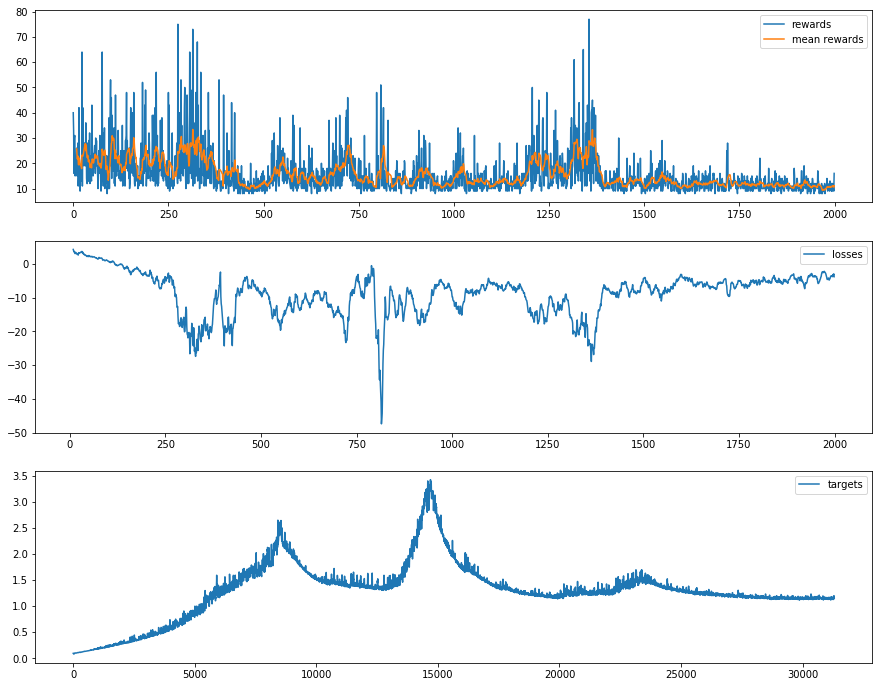

In [52]:
"""
ACTOR-CRITIC method:
- policy gradient method inspired by TD learning
- same as REINFORCE with Baseline, but we bootstrap the value function
"""


class PolicyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(4, 100), nn.ReLU(), nn.Linear(100, 3))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, xs, with_softmax=True):
        xs = torch.FloatTensor(xs)
        ys = self.fc(xs)
        if with_softmax:
            return self.softmax(ys[:2]), ys[2:]
        return ys[:2], ys[2:]


def train_actor_critic(
    env, policy: nn.Module, episodes: int, discount: float,
    learning_rate: float, weight_decay: float, show_stats=True):
        
    episode_rewards = []
    episode_losses = []
    targets = []
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    count_success = 0
    for _ in prange(episodes):
        episode_loss = 0.
        episode_reward = 0.
        
        done = False
        state = env.reset()
        while not done:
            
            # Select an action
            probs, value = policy(state, with_softmax=True)
            distrib = torch.distributions.categorical.Categorical(probs)
            action = distrib.sample().item()
            
            # Execute the action
            next_state, reward, done, _ = env.step(action)
            episode_reward += reward
            
            # Get the target value
            _, next_value = policy(next_state, with_softmax=False)
            target_value = reward + discount * next_value.detach()
            targets.append(target_value.item())
            
            # Compute the value loss and policy loss & update neural net
            optimizer.zero_grad()
            value_loss = torch.pow(value - target_value, 2)
            policy_loss = - torch.log(probs[action]) * (reward - value.item())
            loss = value_loss + policy_loss
            loss.backward()
            optimizer.step()
            
            # Update the policy probabilities
            episode_loss += loss.item()

        # Record history
        episode_rewards.append(episode_reward)
        episode_losses.append(episode_loss)
    
    # Reporting
    if show_stats:
        fig, ax = plt.subplots(figsize=(15, 12), nrows=3)
        ax[0].plot(episode_rewards, label="rewards")
        ax[0].plot(pd.Series(episode_rewards).rolling(10).mean(), label="mean rewards")
        ax[1].plot(pd.Series(episode_losses).rolling(10).sum() / 100., label="losses")
        ax[2].plot(pd.Series(targets).rolling(10).sum() / 100., label="targets")
        for p in ax:
            p.legend()
        plt.show()
    
    
"""
Training
"""

with gym.make("CartPole-v0") as env:
    train_actor_critic(
        env, policy=PolicyNet(), episodes=2000, discount=0.95,
        learning_rate=1e-4, weight_decay=0.0)